### Optimal control of the noisy phenomenological models, e.g. the FHN model
This notebook shows how to compute the optimal control signal for the noisy FHN model for a simple example task. Can be run analogously for the Hopf model.

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import os

while os.getcwd().split(os.sep)[-1] != "neurolib":
    os.chdir('..')

# We import the model, stimuli, and the optimal control package
from neurolib.models.fhn import FHNModel
from neurolib.models.hopf import HopfModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.control.optimal_control import oc_fhn
from neurolib.control.optimal_control import oc_hopf
from neurolib.control.optimal_control.oc_utils.plot_oc import plot_oc_singlenode, plot_oc_network

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We stimulate the system with a known control signal, define the resulting activity as target, and compute the optimal control for this target. In a deterministic system, the optimal control signal should converge to the input signal. In a noisy system, this should not be possible precisely, but only approximately, depending on the noise strength.

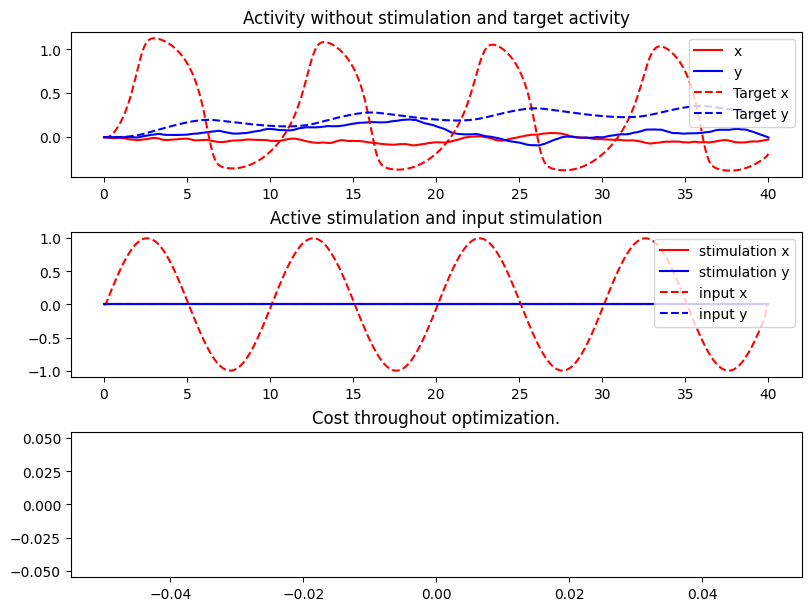

In [42]:
# We import the model
model = FHNModel()
# model = HopfModel()

# Set noise strength to zero to define target state
model.params.sigma_ou = 0.

# Some parameters to define stimulation signals
dt = model.params["dt"]
duration = 40.
amplitude = 1.
period = duration/4.

# We define a "zero-input", and a sine-input
zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
input = np.copy(zero_input)
input[0,1:-2] = np.sin(2.*np.pi*np.arange(0,duration-0.2, dt)/period) # other functions or random values can be used as well

# We set the duration of the simulation and the initial values
model.params["duration"] = duration
x_init = 0.
y_init = 0.
model.params["xs_init"] = np.array([[x_init]])
model.params["ys_init"] = np.array([[y_init]])

# We set the stimulus in x and y variables, and run the simulation in a noise-free system
model.params["x_ext"] = input
model.params["y_ext"] = zero_input
model.run()

# Define the result of the stimulation as target
target = np.concatenate((np.concatenate( (model.params["xs_init"], model.params["ys_init"]), axis=1)[:,:, np.newaxis], np.stack( (model.x, model.y), axis=1)), axis=2)
target_input = np.concatenate( (input,zero_input), axis=0)[np.newaxis,:,:]

# Remove stimuli and re-run the simulation with noise
# Change sigma_ou_parameter to adjust the noise strength
model.params['sigma_ou'] = 0.05
model.params['tau_ou'] = 1.
model.params["x_ext"] = zero_input
model.params["y_ext"] = zero_input
control = np.concatenate( (zero_input,zero_input), axis=0)[np.newaxis,:,:]
model.run()

# combine initial value and simulation result to one array
state = np.concatenate((np.concatenate( (model.params["xs_init"], model.params["ys_init"]), axis=1)[:,:, np.newaxis], np.stack( (model.x, model.y), axis=1)), axis=2)

plot_oc_singlenode(duration, dt, state, target, control, target_input)

The target is a periodic oscillation of x and y variable (computed in deterministic, noise-free system).

The noisy, undistrubed system fluctuates around zero.

For the optimization, you can now set several new parameters:
- M: the number of noise realizations that the algorithm averages over. Default=1
- M_validation: the number of noise realization the final cost is computed from. Default=1000
- validate_per_step: If True, the cost for each step is computed averaging over M_validation instead of M realizations, this takes much longer. Default=False
- method: determines, how the noise averages are computed. Results may vary for different methods depending on the specific task. Choose from ['3']. Default='3'

Please note:
- higher number of iterations does not promise better results for computations in noisy systems. The cost will level off at some iteration number, and start increasing again afterwards. Make sure not to perform too many iterations.
- M, M_validation should increase with sigma_ou model parameter
- validate_per_step does not impact the control result

Let's first optimize with the following parameters: M=20, iterations=100

Compute control for a noisy system


ERROR:root:nan in model output!
ERROR:root:nan in model output!


Mean cost in iteration 0: 8.397951549085091
Diverging model output, decrease step size to 2.5.
Diverging model output, decrease step size to 0.625.
Mean cost in iteration 10: 4.456792890934681
Mean cost in iteration 20: 4.155921933645324
Mean cost in iteration 30: 4.198547293020144
Mean cost in iteration 40: 4.199121142210495
Mean cost in iteration 50: 4.140038785849887
Mean cost in iteration 60: 4.205341150469391
Mean cost in iteration 70: 4.153644278256846
Mean cost in iteration 80: 4.176657433400847
Mean cost in iteration 90: 4.154922007983075
Mean cost in iteration 100: 4.203661164427099
Minimal cost found at iteration 77
Final cost validated with 500 noise realizations : 4.2061537044168675


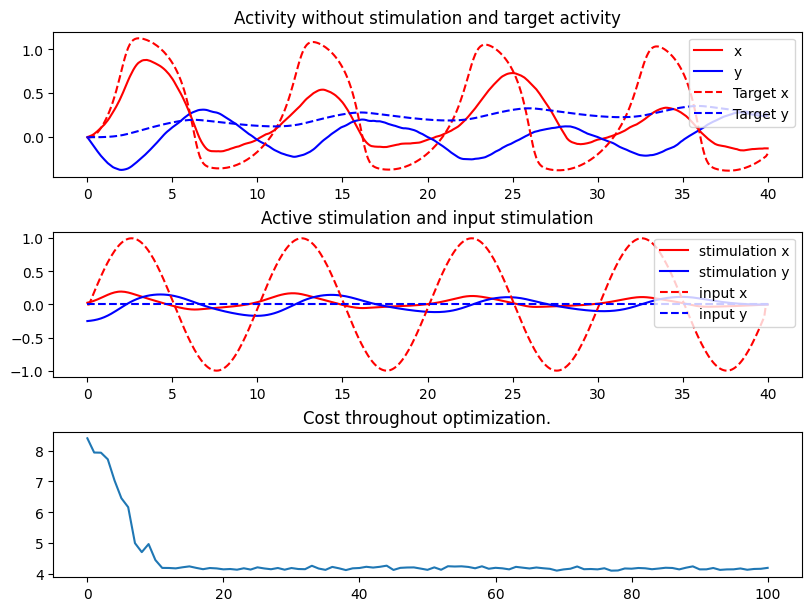

In [43]:
# We set the external stimulation to zero. This is the "initial guess" for the OC algorithm
model.params["x_ext"] = zero_input
model.params["y_ext"] = zero_input

# We load the optimal control class
# print array (optinal parameter) defines, for which iterations intermediate results will be printed
# Parameters will be taken from the input model
if model.name == 'fhn':
    model_controlled = oc_fhn.OcFhn(model, target, w_p=1, w_2=0, print_array=np.arange(0,101,10),
                                M=20, M_validation=500, validate_per_step=True)
elif model.name == 'hopf':
    model_controlled = oc_hopf.OcHopf(model, target, w_p=1, w_2=0, print_array=np.arange(0,101,10),
                                  M=20, M_validation=500, validate_per_step=True)

# We run 100 iterations of the optimal control gradient descent algorithm
model_controlled.optimize(100)

state = model_controlled.get_xs()
control = model_controlled.control

plot_oc_singlenode(duration, dt, state, target, control, target_input, model_controlled.cost_history)


Let's do the same thing with different parameters: M=100, iterations=30

Compute control for a noisy system


ERROR:root:nan in model output!
ERROR:root:nan in model output!
ERROR:root:nan in model output!
ERROR:root:nan in model output!
ERROR:root:nan in model output!
ERROR:root:nan in model output!
ERROR:root:nan in model output!


Mean cost in iteration 0: 8.425725248111394
Diverging model output, decrease step size to 2.5.
Diverging model output, decrease step size to 0.625.
Mean cost in iteration 5: 7.1143355348063455
Mean cost in iteration 10: 5.183603053311947
Mean cost in iteration 15: 4.215974936057603
Mean cost in iteration 20: 3.75048012109378
Mean cost in iteration 25: 3.6983900996238797
Mean cost in iteration 30: 3.667008885579005
Minimal cost found at iteration 30
Final cost validated with 500 noise realizations : 3.7349980427836136


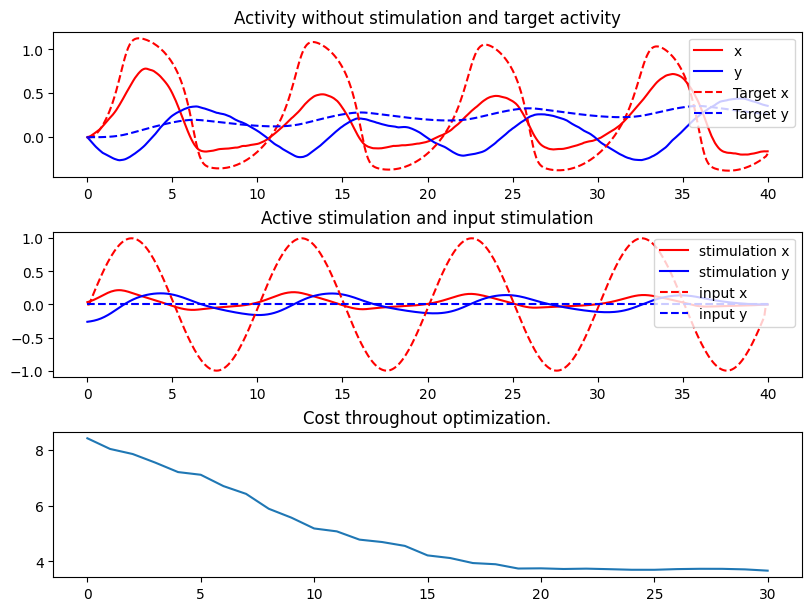

In [44]:
# We set the external stimulation to zero. This is the "initial guess" for the OC algorithm
model.params["x_ext"] = zero_input
model.params["y_ext"] = zero_input

# We load the optimal control class
# print array (optinal parameter) defines, for which iterations intermediate results will be printed
# Parameters will be taken from the input model
if model.name == 'fhn':
    model_controlled = oc_fhn.OcFhn(model, target, w_p=1, w_2=0, print_array=np.arange(0,31,5),
                                M=100, M_validation=500, validate_per_step=True)
elif model.name == 'hopf':
    model_controlled = oc_hopf.OcHopf(model, target, w_p=1, w_2=0, print_array=np.arange(0,31,5),
                                 M=100, M_validation=500, validate_per_step=True)

# We run 30 iterations of the optimal control gradient descent algorithm
model_controlled.optimize(30)

state = model_controlled.get_xs()
control = model_controlled.control

plot_oc_singlenode(duration, dt, state, target, control, target_input, model_controlled.cost_history)

Apparently, for this problem, the first approach is more efficient.

The larger M leads to a more steady decrease in cost in the second approach.

### Network case

Let us know study a simple 2-node network of noisy FHN oscillators. Each population in each node incorporates noise.We first need to define the coupling matrix and the delay matrix. We can then initialize the model.

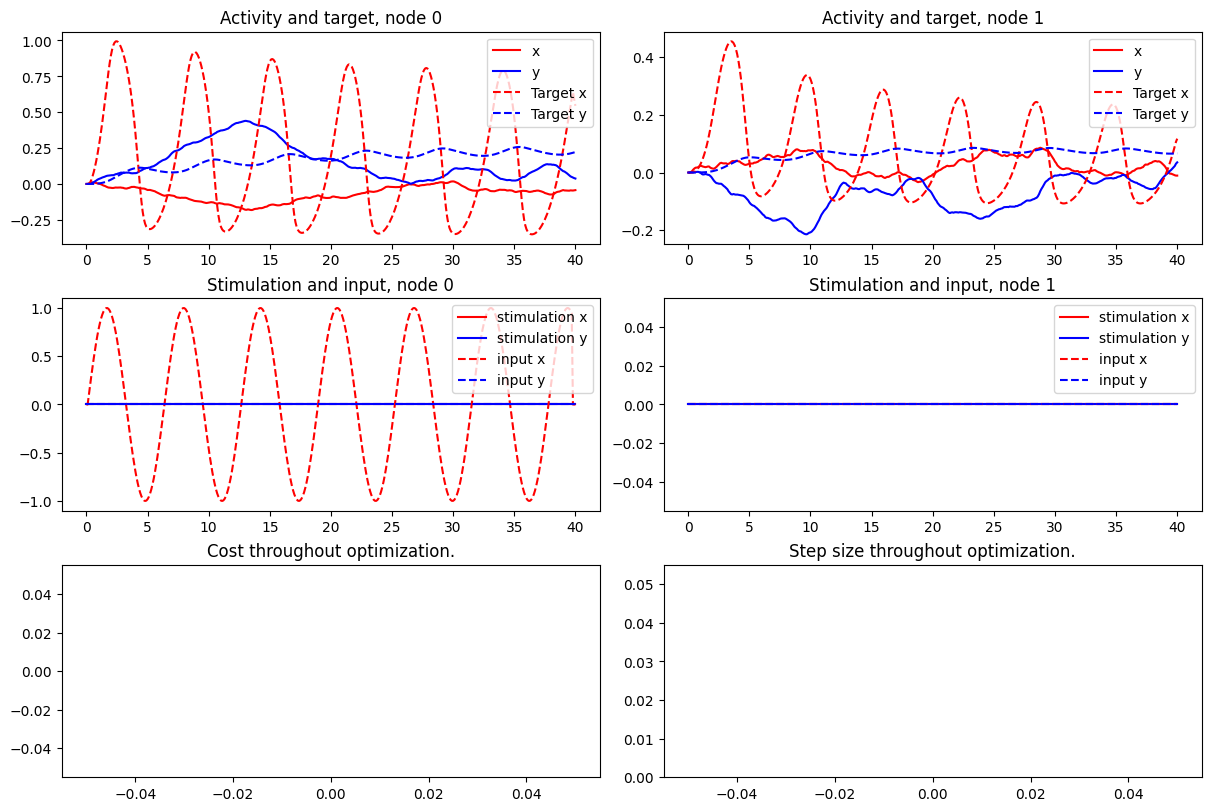

In [39]:
cmat = np.array( [[0., 0.5], [1., 0.]] )  # diagonal elements are zero, connection stregth is 1 (0.5) from node 0 to node 1 (from node 1 to node 0)
dmat = np.array( [[0., 0.], [0., 0.]] )  # no delay

if model.name == 'fhn':
    model = FHNModel(Cmat=cmat, Dmat=dmat)
elif model.name == 'hopf':
    model = HopfModel(Cmat=cmat, Dmat=dmat)

# we define the control input matrix to enable or disable certain channels and nodes
control_mat = np.zeros( (model.params.N, len(model.state_vars)) )
control_mat[0,0] = 1. # only allow inputs in x-channel in node 0

if control_mat[0,0] == 0. and control_mat[1,0] == 0:
    # if x is input channel, high connection strength can lead to numerical issues
    model.params.K_gl = 5. # increase for stronger connectivity, WARNING: too high value will cause numerical problems

# Set noise strength to zero to define target state
model.params['sigma_ou'] = 0.

model.params["duration"] = duration
zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
input = np.copy(zero_input)
input[0,1:-3] = np.sin(np.arange(0,duration-0.3, dt)) # other functions or random values can be used as well
model.params["xs_init"] = np.vstack( [x_init, x_init] )
model.params["ys_init"] = np.vstack( [y_init, y_init] )


# We set the stimulus in x and y variables, and run the simulation
input_nw = np.concatenate( (np.vstack( [control_mat[0,0] * input, control_mat[0,1] * input] )[np.newaxis,:,:],
                            np.vstack( [control_mat[1,0] * input, control_mat[1,1] * input] )[np.newaxis,:,:]), axis=0)
zero_input_nw = np.concatenate( (np.vstack( [zero_input, zero_input] )[np.newaxis,:,:],
                                 np.vstack( [zero_input, zero_input] )[np.newaxis,:,:]), axis=0)

model.params["x_ext"] = input_nw[:,0,:]
model.params["y_ext"] = input_nw[:,1,:]

model.run()

# Define the result of the stimulation as target
target = np.concatenate( (np.concatenate( (model.params["xs_init"], model.params["ys_init"]), axis=1)[:,:, np.newaxis], np.stack( (model.x, model.y), axis=1)), axis=2)

# Remove stimuli and re-run the simulation
model.params['sigma_ou'] = 0.05
model.params['tau_ou'] = 1.
model.params["x_ext"] = zero_input_nw[:,0,:]
model.params["y_ext"] = zero_input_nw[:,0,:]
model.run()

# combine initial value and simulation result to one array
state =  np.concatenate( (np.concatenate( (model.params["xs_init"], model.params["ys_init"]), axis=1)[:,:, np.newaxis], np.stack( (model.x, model.y), axis=1)), axis=2)

plot_oc_network(model.params.N, duration, dt, state, target, zero_input_nw, input_nw)

Let's first optimize with the following parameters: M=20, iterations=100

Compute control for a noisy system
Mean cost in iteration 0: 0.6480573845458085
Mean cost in iteration 10: 0.6838952117100616
Mean cost in iteration 20: 0.6852388334374404
Mean cost in iteration 30: 0.6738159553915756
Mean cost in iteration 40: 0.6875807459450143
Mean cost in iteration 50: 0.6954820597117753
Mean cost in iteration 60: 0.7007287969794148
Mean cost in iteration 70: 0.6994622455385984
Mean cost in iteration 80: 0.703510693438103
Mean cost in iteration 90: 0.6944956673787209
Mean cost in iteration 100: 0.6962699679281886
Minimal cost found at iteration 1
Final cost validated with 500 noise realizations : 0.6467380332491472


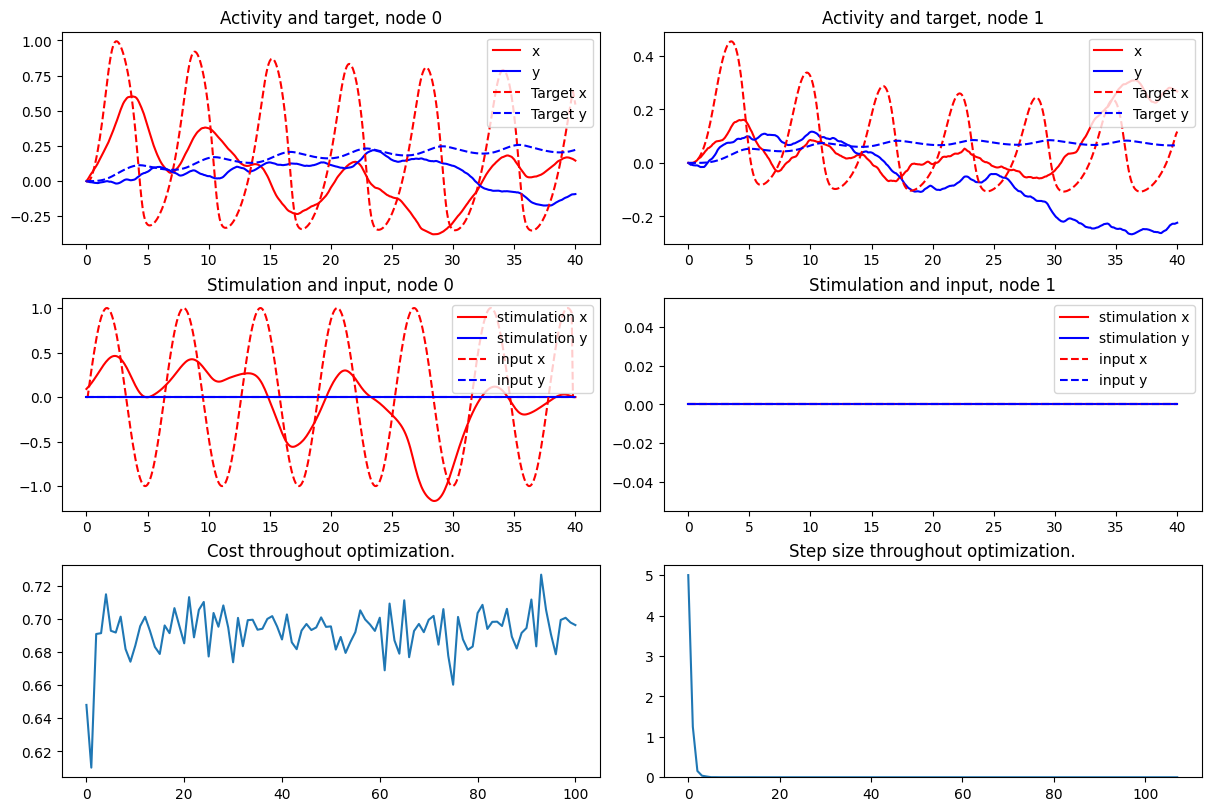

In [40]:
# we define the precision matrix to specify, in which nodes and channels we measure deviations from the target
prec_mat = np.zeros( (model.params.N, len(model.output_vars)) )
prec_mat[1,0] = 1. # only measure in x-channel in node 1

# We set the external stimulation to zero. This is the "initial guess" for the OC algorithm
model.params["x_ext"] = zero_input_nw[:,0,:]
model.params["y_ext"] = zero_input_nw[:,0,:]

# We load the optimal control class
# print array (optinal parameter) defines, for which iterations intermediate results will be printed
# Parameters will be taken from the input model
if model.name == 'fhn':
    model_controlled = oc_fhn.OcFhn(model,
                                target,
                                w_p=1,
                                w_2=0,
                                print_array=np.arange(0,101,10),
                                control_matrix=control_mat,
                                precision_matrix=prec_mat,
                                M=20,
                                M_validation=500,
                                validate_per_step=True)
elif model.name == 'hopf':
    model_controlled = oc_hopf.OcHopf(model,
                                  target,
                                  w_p=1,
                                  w_2=0,
                                  print_array=np.arange(0,101,10),
                                  control_matrix=control_mat,
                                  precision_matrix=prec_mat,
                                  M=20,
                                  M_validation=500,
                                  validate_per_step=True)

# We run 100 iterations of the optimal control gradient descent algorithm
model_controlled.optimize(100)

state = model_controlled.get_xs()
control = model_controlled.control

plot_oc_network(model.params.N, duration, dt, state, target, control, input_nw, model_controlled.cost_history, model_controlled.step_sizes_history)

Let's do the same thing with different parameters: M=100, iterations=30

Compute control for a noisy system
Mean cost in iteration 0: 0.6521243902912178
Mean cost in iteration 5: 0.5661944445856116
Mean cost in iteration 10: 0.4783810260237329
Mean cost in iteration 15: 0.4720257258568143
Mean cost in iteration 20: 0.47474716377504933
Mean cost in iteration 25: 0.4754530097390762
Mean cost in iteration 30: 0.4620161067731942
Minimal cost found at iteration 29
Final cost validated with 500 noise realizations : 0.4664976615289385


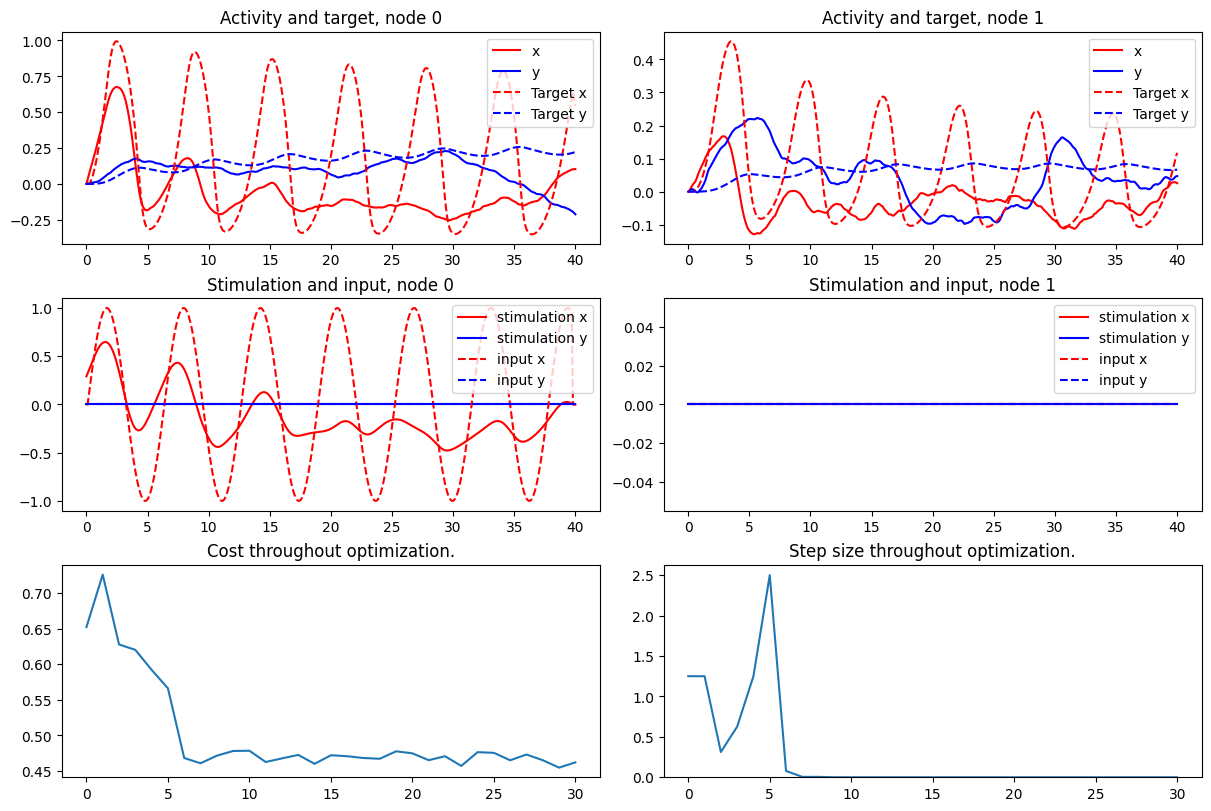

In [41]:
# We set the external stimulation to zero. This is the "initial guess" for the OC algorithm
model.params["x_ext"] = zero_input_nw[:,0,:]
model.params["y_ext"] = zero_input_nw[:,0,:]

# We load the optimal control class
# print array (optinal parameter) defines, for which iterations intermediate results will be printed
# Parameters will be taken from the input model
if model.name == 'fhn':
    model_controlled = oc_fhn.OcFhn(model,
                                target,
                                w_p=1,
                                w_2=0,
                                print_array=np.arange(0,31,5),
                                control_matrix=control_mat,
                                precision_matrix=prec_mat,
                                M=100,
                                M_validation=500,
                                validate_per_step=True)

elif model.name == 'hopf':
    model_controlled = oc_hopf.OcHopf(model,
                                target,
                                w_p=1,
                                w_2=0,
                                print_array=np.arange(0,31,5),
                                control_matrix=control_mat,
                                precision_matrix=prec_mat,
                                M=100,
                                M_validation=500,
                                validate_per_step=True)
    
# We run 30 iterations of the optimal control gradient descent algorithm
model_controlled.optimize(30)

state = model_controlled.get_xs()
control = model_controlled.control

plot_oc_network(model.params.N, duration, dt, state, target, control, input_nw, model_controlled.cost_history, model_controlled.step_sizes_history)